![Chinstrap, Gentoo, and Adelie penguin clipart](lter_penguins.png)

# Classifying Palmer Penguins

In this blog post, we are going to go use a simplified, but standard machine learning workflow to determine the smallest number of features needed to confidently determine the species of a pengiun. 

## Download Training Data
First, we download our given training data. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

# Load training data
train_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

## Prepare Training Data
Next, we tidy up our data. We remove any columns that irrlevant to determining the species of a penguin and modify any qualitative features (e.g. sex, clutch completion, island), so that they are represented through numerical values, since strings are difficult to work with. 

In [2]:
le = LabelEncoder()
le.fit(train["Species"])

"""
Prepare qualitative data and mark species as labels
"""
def prepare_data(df):
    df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
    df = df[df["Sex"] != "."]
    df = df.dropna()
    y = le.transform(df["Species"])
    df = df.drop(["Species"], axis = 1)
    df = pd.get_dummies(df)
    return df, y

# Prepare training data
X_train, y_train = prepare_data(train)

## Explore: Feature Selection

Now that we have prepared our training data, we want to figure our which three features of the data (two quantitative and one qualitative) will allow a model to achieve 100% testing accuracy when trained on those features.  

The first way in which we tried to select these features was through the `SelectKBest` and `f_classif` functions in the `sklearn.feature_selection` package. 

In [3]:
# Resource: https://www.datatechnotes.com/2021/02/seleckbest-feature-selection-example-in-python.html

from sklearn.feature_selection import SelectKBest, f_classif

all_qual_cols = ["Island_Biscoe", "Island_Dream", "Island_Torgersen", "Clutch Completion_No", "Clutch Completion_Yes", "Sex_FEMALE", "Sex_MALE"]
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)']

# Pick quantatative features 
X_quant = X_train[all_quant_cols]
quant_select = SelectKBest(f_classif, k=2).fit(X_quant, y_train)
mask = quant_select.get_support()
quant_names = X_quant.columns[mask]

# Pick qualatative features
X_qual = X_train[all_qual_cols]
qual_selected = SelectKBest(f_classif, k=3).fit(X_qual, y_train)
mask = qual_selected.get_support()
qual_names = X_qual.columns[mask]

features = np.concatenate((quant_names, qual_names))

In [4]:
print(f"quant_names: {quant_names}")
print(f"qual_names: {qual_names}")
print(f"features: {features}")

quant_names: Index(['Culmen Length (mm)', 'Flipper Length (mm)'], dtype='object')
qual_names: Index(['Island_Biscoe', 'Island_Dream', 'Island_Torgersen'], dtype='object')
features: ['Culmen Length (mm)' 'Flipper Length (mm)' 'Island_Biscoe' 'Island_Dream'
 'Island_Torgersen']


When we inspect the features `SelectKBest` selected based on the `f_classif` score function, we see that it found the quantative features of *Culmen Length (mm)* and *Flipper Length (mm)* and qualitative *Island* feature to be the best features for the training data.  

Another way we could have selected features was through an exhaustive search that uses the `combinations` function from the `itertools` package. To guard ourselves from overfitting issues, we use cross validation throughout this process with Logistic Regression as our model. 

In [5]:
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

all_qual_cols = ["Island", "Clutch", "Sex"]
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)']

# Create dataframe to better inspect the scores
pd.set_option('max_colwidth', 100)
scores_df = pd.DataFrame(columns=['Columns', 'Score'])

# Go through possible combinations of features and train model on them 
#     Using 1 qualitative and 2 quantiative 
for qual in all_qual_cols: 
    qual_cols = [col for col in X_train.columns if qual in col ]
    for pair in combinations(all_quant_cols, 2):
        cols = list(pair) + qual_cols 
        # print(cols)
        # Using logistic regression for modeling 
        LR = LogisticRegression()
        # Incorportating cross validation? 
        cv_scores = cross_val_score(LR, X_train[cols], y_train, cv=10)
        mean_score = cv_scores.mean()
        scores_df = scores_df.append({'Columns': cols, 'Score': mean_score.round(3)}, ignore_index=True)

scores_df = scores_df.sort_values(by='Score', ascending=False).reset_index(drop=True)
features = scores_df.iloc[0,0]
features

['Culmen Length (mm)',
 'Culmen Depth (mm)',
 'Island_Biscoe',
 'Island_Dream',
 'Island_Torgersen']

By inspecting the features with the highest score that the exhaustive search, we see that it has the same qualitative feature selection of `Island` as our `SelectKBest` method, but different quanative feature selections. Here instead of the `Flipper Length (mm)` resulting in a higher score, it found `Culmen Depth (mm)` to be more promising.  

To figure out whether `Flipper Length (mm)` and `Culmen Length` or `Culmen Depth (mm)` and `Culmen Length` is more promising, let's inspect what they look like when graphed. 

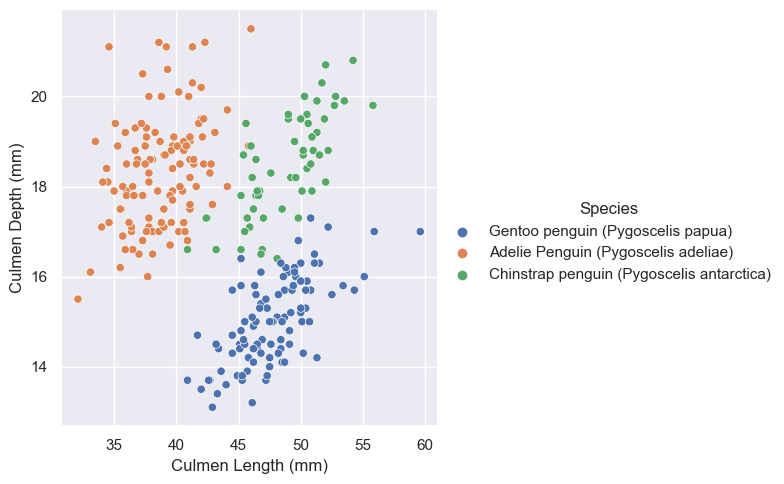

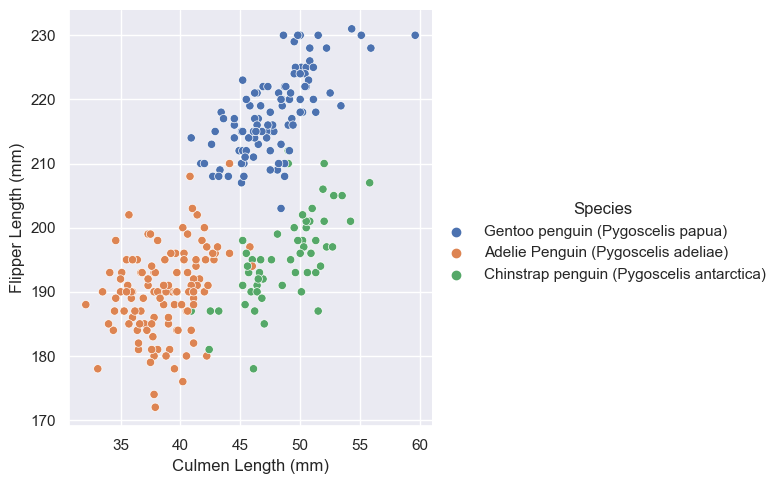

In [6]:
import seaborn as sns
sns.set_theme()
sns.relplot(
    data=train,
    x="Culmen Length (mm)", y="Culmen Depth (mm)", hue="Species"
)
sns.relplot(
    data=train,
    x="Culmen Length (mm)", y='Flipper Length (mm)', hue="Species"
)

Based on these graphs, it looks like Culmen Depth and Culmen Length may be the better quantative options for they look more separated. 

## Explore: Modeling

In [7]:
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import numpy as np

def decision_region_panel(X, y, model, qual_features):  
    p = len(qual_features)
    fig, axarr = plt.subplots(1, p, figsize=(4*p,4))
    for i in range(p):

        filler_feature_values = {2+j: 0 for j in range(p)}
        
        filler_feature_values.update({2+i: 1})
        
        ix = X[qual_features[i]] == 1

        ax = axarr[i]
        # print(f"{X[ix]=}")
        plot_decision_regions(np.array(X[ix]), y[ix], clf=model,
                            filler_feature_values=filler_feature_values,
                            filler_feature_ranges={2+j: 0.1 for j in range(p)},
                            legend=2, ax=ax)

        ax.set_xlabel(X.columns[0])
        ax.set_ylabel(X.columns[1])

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, 
          ["Adelie", "Chinstrap", "Gentoo"],
           framealpha=0.3, scatterpoints=1)
        
    # Adding axes annotations
    fig.suptitle(f'Accuracy = {model.score(X, y).round(3)}')
    plt.tight_layout()
    plt.show()

### DecisionTreeClassifier

0.9767692307692307 3
features: ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']
qual_names: Index(['Island_Biscoe', 'Island_Dream', 'Island_Torgersen'], dtype='object')


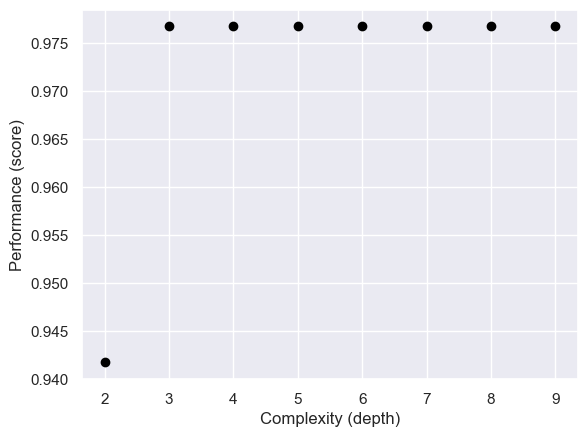

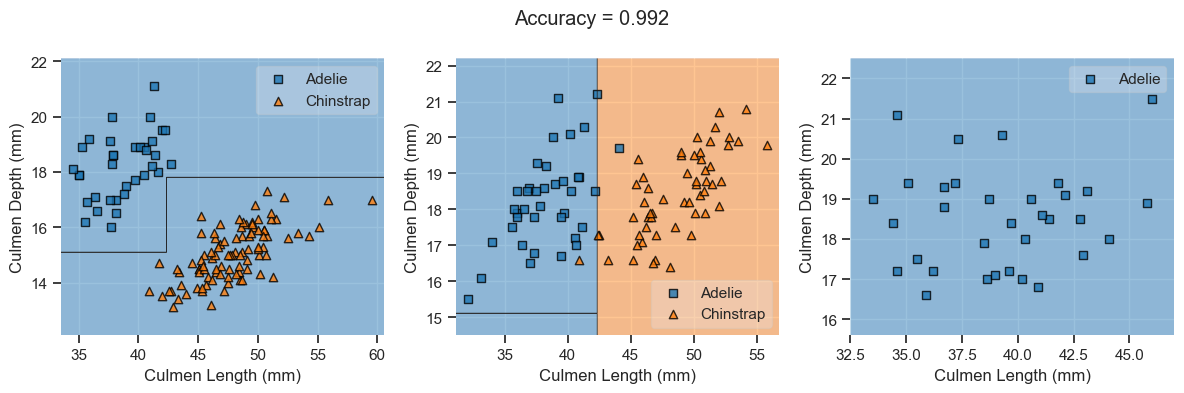

In [8]:
#FIND MAX DEPTH OF TREE 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

fig, ax = plt.subplots(1)

max_score = 0
best_depth = 0
for d in range(2, 10):
    # USING DECISION TREE CLASSIFER 
    T = DecisionTreeClassifier(max_depth = d)
    cv_mean = cross_val_score(T, X_train[features], y_train, cv = 10).mean()
    ax.scatter(d, cv_mean, color = "black")
    if cv_mean > max_score:
        max_score = cv_mean 
        best_depth = d

labs = ax.set(xlabel = "Complexity (depth)", ylabel = "Performance (score)")
       
print(max_score, best_depth)

DTC = DecisionTreeClassifier(max_depth = best_depth)
DTC.fit(X_train[features], y_train)
# print(DTC.score(X_train[features], y_train))
print(f"features: {features}")
print(f"qual_names: {qual_names}")
decision_region_panel(X_train[features], y_train, DTC, qual_names)

### SVC

0.9846153846153847 0.02


SVC(gamma=0.02)

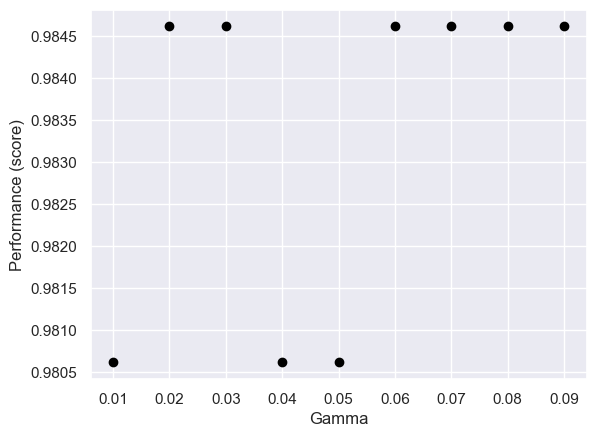

In [9]:
#FIND GAMMA 
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

fig, ax = plt.subplots(1)

max_score = 0
best_gamma = 0
for g in range(1, 10):
    little_g = g / 100
    # USING DECISION TREE CLASSIFER 
    svc = SVC(gamma = little_g, kernel = "rbf")
    cv_mean = cross_val_score(svc, X_train[features], y_train, cv = 10).mean()
    ax.scatter(little_g, cv_mean, color = "black")
    if cv_mean > max_score:
        max_score = cv_mean 
        best_gamma = little_g

labs = ax.set(xlabel = "Gamma", ylabel = "Performance (score)")
       
print(max_score, best_gamma)

svc = SVC(gamma = best_gamma) 
svc.fit(X_train[features], y_train)
# print(svc.score(X_train[features], y_train))
# decision_region_panel(X_train[features], y_train, svc, qual_names)


### LogisticRegression

features: ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']
qual_names: Index(['Island_Biscoe', 'Island_Dream', 'Island_Torgersen'], dtype='object')


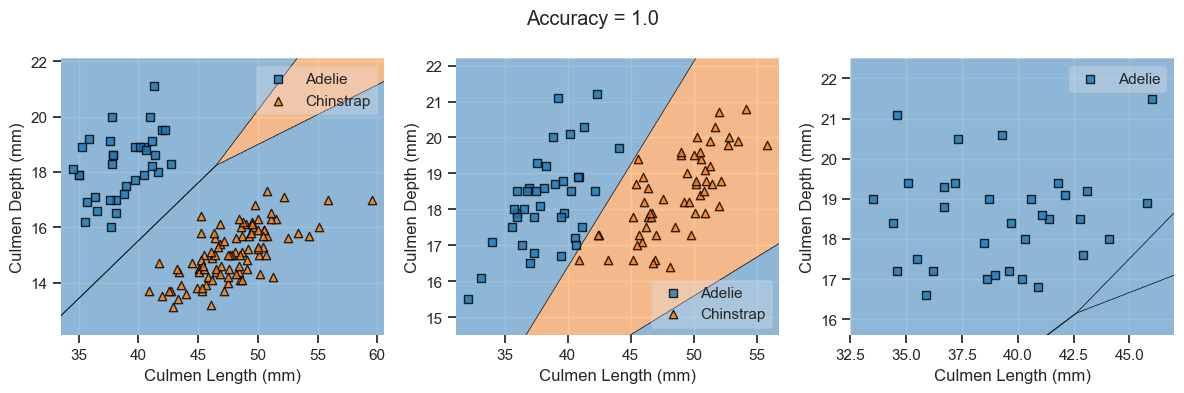

In [10]:
LR = LogisticRegression()
LR.fit(X_train[features], y_train)
# print(LR.score(X_train[features], y_train))
print(f"features: {features}")
print(f"qual_names: {qual_names}")
decision_region_panel(X_train[features], y_train, LR, qual_names)

## Testing

In [11]:
# TESTING
test_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)
X_test, y_test = prepare_data(test)

In [17]:
print(DTC.score(X_test[features], y_test))
print(svc.score(X_test[features], y_test))
print(LR.score(X_test[features], y_test))
# YOU GET 100% TESTING ACCURACY WITH QUANTATIVE culmen length and culmen depth 
# Show graphs

0.9852941176470589
0.9411764705882353
1.0


## Results 

# NOT USING YET

In [13]:
from mlxtend.plotting import plot_decision_regions
# DTC = DecisionTreeClassifier(max_depth = best_depth)
# DTC.fit(np.array(X_train[features]), y_train)

def training_decision_regions(model, cols, **kwargs):
    m = model(**kwargs)
    m.fit(np.array(X_train[cols]), y_train)
    plot_decision_regions(np.array(X_train[cols]), y_train, clf = m)
    ax = plt.gca()
    ax.set(xlabel = cols[0], 
                  ylabel = cols[1], 
                  title = f"Training accuracy = {m.score(np.array(X_train[cols]), y_train).round(2)}")

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, 
              species, 
              framealpha=0.3, 
              scatterpoints=1)

 # training_decision_regions(DecisionTreeClassifier, features, max_depth = best_depth)

In [14]:
# INSPECTING DATA 
# print("BASE RATES") 
# print("y_train:", y_train)
# print("species 0 count:", np.count_nonzero(y_train == 0), "percentage:", np.count_nonzero(y_train == 0)/np.size(y_train)) 
# print("species 1 count:", np.count_nonzero(y_train == 1), "percentage:", np.count_nonzero(y_train == 1)/np.size(y_train)) 
# print("species 2 count:", np.count_nonzero(y_train == 2), "percentage:", np.count_nonzero(y_train == 2)/np.size(y_train)) 

# WAIT SO IS OUR BASE RATE THE AVERAGE OF THESE? 